In [2]:
from utilities.preprocessing import TwitterReader
from utilities.preprocessing import extract_emojis,find_mentions,clean_data,stratified_train_eval_test_split
import itertools
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from emoji import EMOJI_DATA
import os
from pathlib import Path
from hparam_tuning_eval import save_best_params,filter_params
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from itertools import product
from utilities.preprocessing import remove_urls
from utilities.dataloading import create_dataloader
from train import train_epoch,train_model,evaluate
from utilities.tokenizers import CharacterTokenizer
from model import TransformerClassifier

In [3]:
#paths
split_folder=Path('./data/split')
hparameter_output_path=Path('output/hparam_result/best_params.json')

In [4]:
#Read in the data
reader=TwitterReader('./data')

all_tweets,labels=reader.get_all_tweets(return_labels=True)
postive_tweets=reader.tweets['positive']
negative_tweets=reader.tweets['negative']
neutral_tweets=reader.tweets['neutral']




**Let's see a few examples per class**

In [5]:
postive_tweets[:10]

["@VirginAmerica plus you've added commercials to the experience... tacky.",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p",
 "@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn",
 '@VirginAmerica Thanks!',
 "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 'I ❤️ flying @VirginAmerica. ☺️👍']

In [6]:
negative_tweets[:10]

['@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.it's really the only bad thing about flying VA",
 '@VirginAmerica SFO-PDX schedule is still MIA.',
 "@VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!",
 '@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???',
 '@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet',
 "@VirginAmerica status match program.  I applied and it's been three weeks.  Called and emailed with no response.",
 "@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site

In [7]:
neutral_tweets[:10]

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
 '@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24',
 '@VirginAmerica will you be making BOS&gt;LAS non stop permanently anytime soon?',
 "@VirginAmerica do you miss me? Don't worry we'll be together very soon.",
 '@VirginAmerica LAX to EWR - Middle seat on a red eye. Such a noob maneuver. #sendambien #andchexmix',
 '@VirginAmerica Are the hours of operation for the Club at SFO that are posted online current?',
 'Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP',
 '@VirginAmerica when can I book my flight to Hawaii??']

****Observations:****

We see emojis, urls, mentions

The tweet corresponding to each airline is mostly (but not always) at the very front e.g. **'I ❤️ flying @VirginAmerica. ☺️👍'**

Tweets have varying lengths.

In [8]:
sentiment_dict=reader.sentiment_mapping
label_to_sentiment={v:k for k,v in sentiment_dict.items()}
label_to_sentiment

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [9]:
#Create pandas DataFrames
tweets_df=pd.DataFrame({'tweet':all_tweets,'sentiment':labels})
tweets_df['sentiment']=tweets_df['sentiment'].apply(lambda x:label_to_sentiment[x])
tweets_df

,tweet,sentiment
0,@VirginAmerica plus you've added commercials t...,positive
1,"@VirginAmerica yes, nearly every time I fly VX...",positive
2,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
3,"@VirginAmerica it was amazing, and arrived an ...",positive
4,@VirginAmerica I &lt;3 pretty graphics. so muc...,positive
...,...,...
14635,@AmericanAir i need someone to help me out,neutral
14636,"@AmericanAir guarantee no retribution? If so, ...",neutral
14637,"“@AmericanAir: @TilleyMonsta George, that does...",neutral
14638,@AmericanAir Please bring American Airlines to...,neutral


**Length and sentiment distribution**

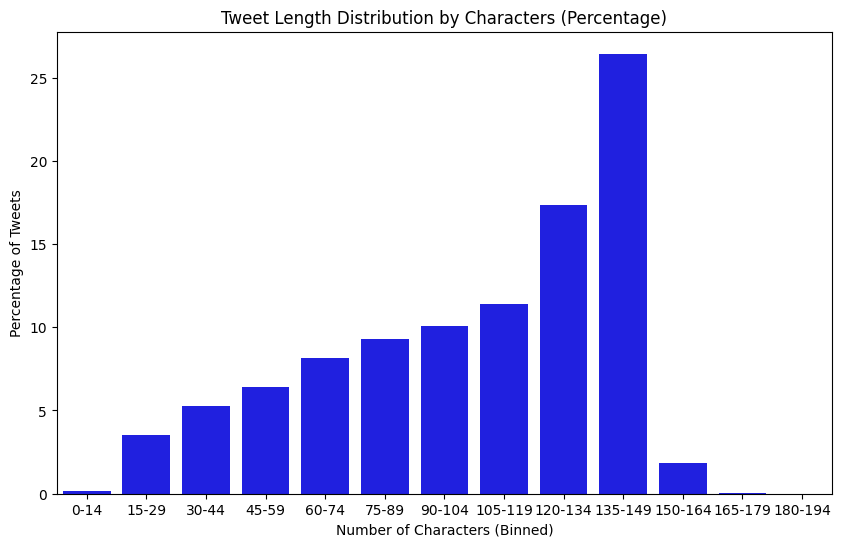

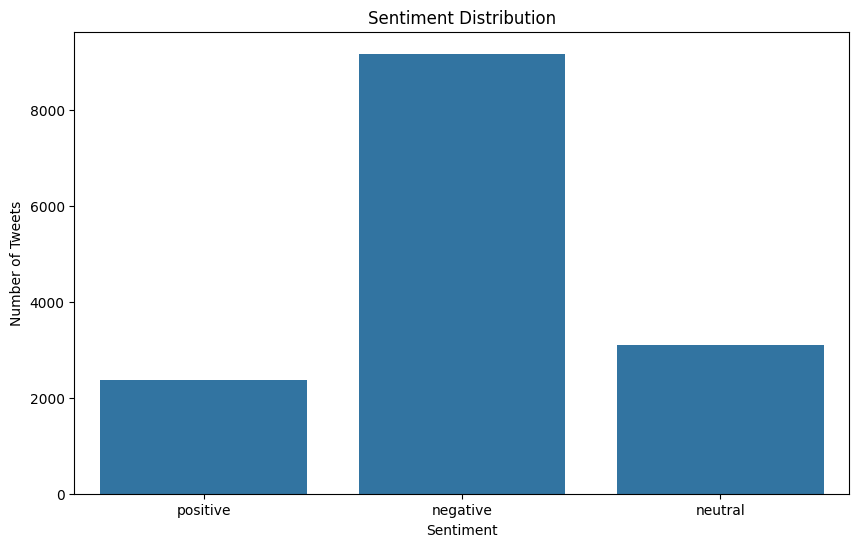

In [10]:


# Character-level Tokenization
tweets_df['char_tokens'] = tweets_df['tweet'].apply(list)

# Character Length Distribution
tweets_df['tweet_length'] = tweets_df['char_tokens'].apply(len)

max_length = tweets_df['tweet_length'].max()
bin_width = 15
bins = np.arange(0, max_length + bin_width, bin_width)
intervals = [f'{i}-{i + bin_width - 1}' for i in bins[:-1]]

tweets_df['length_bin'] = pd.cut(tweets_df['tweet_length'], bins=bins, labels=intervals, right=False)

# Calculate percentages
length_bin_counts = tweets_df['length_bin'].value_counts(normalize=True) * 100
length_bin_counts = length_bin_counts.sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=length_bin_counts.index, y=length_bin_counts.values, color='blue')
plt.title('Tweet Length Distribution by Characters (Percentage)')
plt.xlabel('Number of Characters (Binned)')
plt.ylabel('Percentage of Tweets')
plt.show()

# Sentiment Distribution plot

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=tweets_df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()



**Emojis**

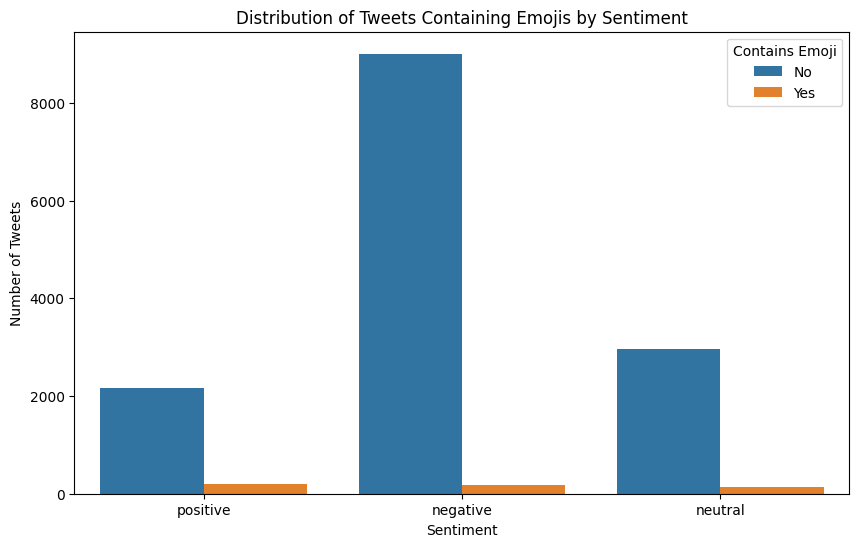

In [11]:
# Extract emojis from each tweet


tweets_df['emojis'] = tweets_df['tweet'].apply(extract_emojis)

# Create a column indicating if the tweet contains at least one emoji
tweets_df['contains_emoji'] = tweets_df['emojis'].apply(lambda x: len(x) > 0)

# Plot the distribution of tweets containing emojis across sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', hue='contains_emoji', data=tweets_df)
plt.title('Distribution of Tweets Containing Emojis by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.legend(title='Contains Emoji', loc='upper right', labels=['No', 'Yes'])
plt.show()


In [12]:

#number of DISTINCT CHARACTERS in ALL tweets
body=''.join(all_tweets)
len(set(body))

236

In [13]:

emoji_counter=Counter(extract_emojis(body))
emoji_counter


Counter({'🙏': 125,
         '😂': 62,
         '✈': 57,
         '😭': 44,
         '👍': 42,
         '😡': 33,
         '😢': 32,
         '❤': 31,
         '😊': 31,
         '👏': 28,
         '😉': 20,
         '✌': 19,
         '😁': 18,
         '😩': 18,
         '😒': 17,
         '😃': 16,
         '👎': 16,
         '👌': 14,
         '🆘': 14,
         '💙': 13,
         '😄': 12,
         '😔': 11,
         '☺': 10,
         '😍': 10,
         '💔': 10,
         '😕': 9,
         '💗': 8,
         '🎉': 8,
         '❄': 8,
         '😤': 8,
         '🙌': 7,
         '😜': 7,
         '😞': 7,
         '😑': 7,
         '💕': 6,
         '😎': 6,
         '👠': 6,
         '😀': 6,
         '🌴': 6,
         '⭐': 6,
         '🎀': 6,
         '😏': 5,
         '👀': 5,
         '😥': 5,
         '💩': 5,
         '😐': 5,
         '😳': 5,
         '♥': 4,
         '🙅': 4,
         '💯': 4,
         '😘': 4,
         '💺': 4,
         '☀': 4,
         '😫': 4,
         '😖': 4,
         '😠': 4,
         '🍅': 4,
     

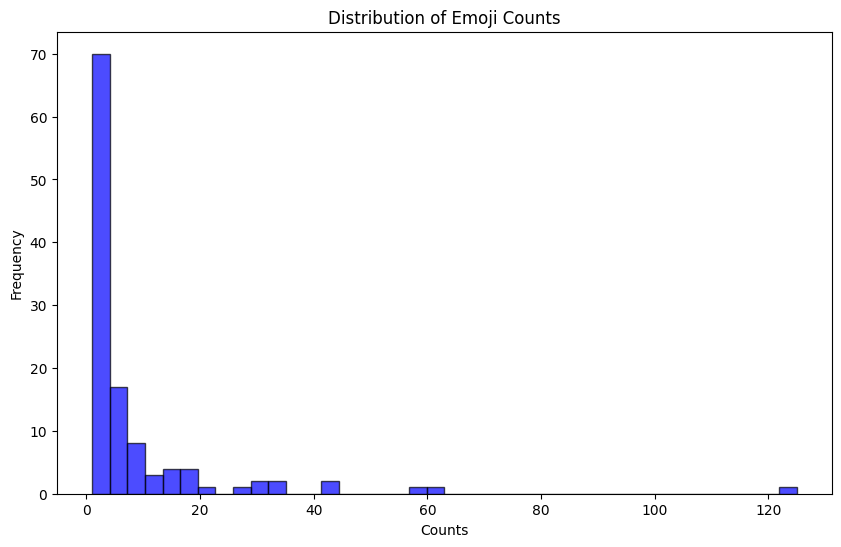

In [14]:
counts = list(emoji_counter.values())

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=40, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Emoji Counts')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()

---Comments on emojiis ---

We see that most emojis have scarce appearances in the tweets

Most of them appear less than 4 times in the entire body and there are a lot that appear just once. 

Assuming this distribution is representative of the specific airline tweet's universe, this means that we will probably be getting a lot of unknown emojis in out-of-sample distributions.

Thankfully we will be introducing an UNKNOWN TOKEN character later for tokenization

**Mentions**

In [15]:
#first mention is usually an airline, but not always, as guessed from the beginning of sentences above. 
Counter([find_mentions(x)[0].lower().strip() for x in all_tweets])

Counter({'@united': 3816,
         '@usairways': 2905,
         '@americanair': 2754,
         '@southwestair': 2417,
         '@jetblue': 2215,
         '@virginamerica': 503,
         '@nrhodes85': 2,
         '@deltaassist': 2,
         '@dadboner': 1,
         '@imaginedragons': 1,
         '@eatgregeat': 1,
         '@ninadavuluri': 1,
         '@virginamericawjere': 1,
         '@lindaswc': 1,
         '@melissaafrancis': 1,
         '@unitedyou': 1,
         '@kciairport': 1,
         '@nytimes': 1,
         '@sb5551': 1,
         '@timbennettg3': 1,
         '@sarahpompei': 1,
         '@andrewfallis': 1,
         '@scm1133': 1,
         '@djevolutionhd': 1,
         '@malhoit': 1,
         '@vanessaannz': 1,
         '@mandarinjourney': 1,
         '@internjohnradio': 1,
         '@hillaconlin': 1,
         '@catfoodbeerglue': 1,
         '@shannonwoodward': 1,
         '@albertbreer': 1,
         '@ods1819': 1,
         '@chasefoster': 1})

In [16]:
#subsequent mentions look more random
Counter(set(itertools.chain(*[find_mentions(x)[1:] for x in all_tweets if len(find_mentions(x))>=2])))

Counter({'@DatingRev': 1,
         '@Cowboycerrone': 1,
         '@hemispheresmag': 1,
         '@fitbit': 1,
         '@TatianaKing': 1,
         '@Skywest': 1,
         '@VerizonWireless': 1,
         '@PaytonTaylor129': 1,
         '@BBBNE_SD_KS_IA': 1,
         '@NTrustOpen': 1,
         '@jeffsmisek': 1,
         '@AlaskaAir': 1,
         '@NinaDavuluri': 1,
         '@mco': 1,
         '@dgruber1700': 1,
         '@campilley': 1,
         '@MrAndyEp': 1,
         '@retailbagholder': 1,
         '@EdPlotts': 1,
         '@CallMeStanley7': 1,
         '@Gregm528': 1,
         '@Imaginedragons': 1,
         '@sxsw': 1,
         '@SAMoore10': 1,
         '@UCtraveladvisor': 1,
         '@44Stocker': 1,
         '@husainhaqqani': 1,
         '@visualclubconcepts': 1,
         '@aegeanairlines': 1,
         '@ComClassic': 1,
         '@cspkcats': 1,
         '@USChamber': 1,
         '@ClinicPolly': 1,
         '@priceline': 1,
         '@CBSPhilly': 1,
         '@zakkohane': 1,
      

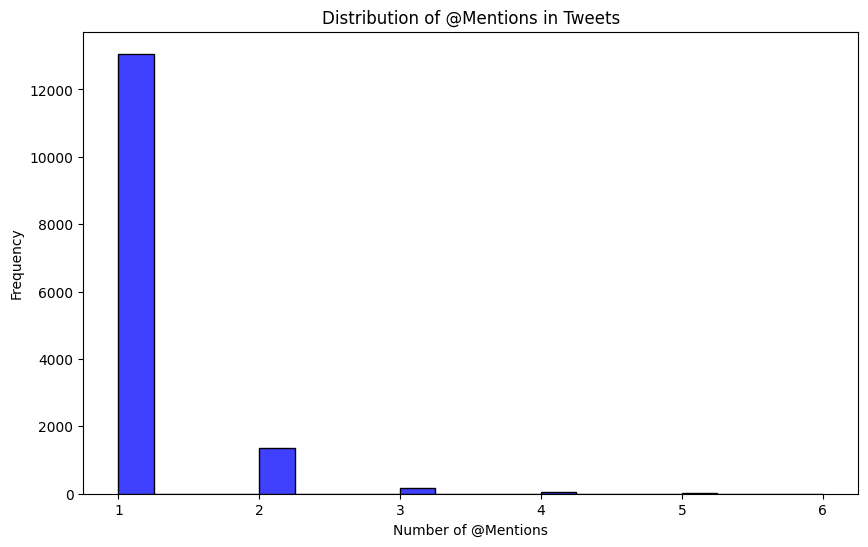

In [17]:
# Function to count mentions in a tweet
def count_mentions(tweet):
    mentions = re.findall(r'@\w+', tweet)
    return len(mentions)

mention_counts = [count_mentions(tweet) for tweet in all_tweets]

# Create a DataFrame for plotting/ not necessary- useful for seaborn
mention_df = pd.DataFrame(mention_counts, columns=['mention_count'])

#hist plot
plt.figure(figsize=(10, 6))
sns.histplot(mention_df['mention_count'], bins=20, kde=False, color='blue', edgecolor='black')
plt.title('Distribution of @Mentions in Tweets')
plt.xlabel('Number of @Mentions')
plt.ylabel('Frequency')
plt.show()

**Cleaning the data**

In [18]:
#remove excess white spaces, remove urls and remove mentions
tweets_cleaned=[clean_data(x) for x in all_tweets]

In [19]:
tweets_cleaned[:20]

["plus you've added commercials to the experience... tacky.",
 'yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "Well, I didn't…but NOW I DO! :-D",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "This is such a great deal! Already thinking about my 2nd trip to  &amp; I haven't even gone on my 1st trip yet! ;p",
 "I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel",
 'Thanks!',
 "So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo",
 'I ❤️ flying . ☺️👍',
 'you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.',
 'I love this graphic.',
 'I love the hipster innovation. You are a feel good brand.',
 'this is great news! America could start flights to Hawaii by end of year  via',
 'Moodlighting is the only way to fly! Best ex

**Splitting cleaned data into train, eval, test sets**

Given the findings above, we perform a stratified split based on a combined feature

In [20]:
#Based on the above discussion, we split all_tweets in train, eval and test sets using a combined feature consisting of the labels and length categories of the tweets.

# Calculate the length of each item in X
lengths = [len(item) for item in all_tweets]

# Create 3 length categories , ie short, medium, long
length_categories = pd.cut(lengths, bins=3, labels=False)

# Create a combined feature by combining labels and length categories
combined_feature = [(label, length_category) for label, length_category in zip(labels, length_categories)]

In [21]:
X_train, X_val, X_test, y_train, y_val, y_test=stratified_train_eval_test_split(all_tweets,labels,combined_feature,eval_test_size=0.2, second_split=0.5, random_state=42)

In [22]:
len(X_train),len(X_val),len(X_test),len(y_train),len(y_val),len(y_test)

(11712, 1464, 1464, 11712, 1464, 1464)

In [24]:
splits = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test
    }

for prefix, data in splits.items():
    os.makedirs(split_folder, exist_ok=True)
    file_path = split_folder / f"{prefix}.txt"
    with open(file_path, 'w', encoding='utf-8') as file:
        for item in data:
            file.write(f"{item}\n")